In [ ]:
# Instala a biblioteca ultralytics para uso do modelo YOLO
# !pip install ultralytics

In [ ]:
# para acessar a webcam e exibir o vídeo em tempo real.
#!pip install pygame
# NÃO BAIXAR

In [ ]:
#!pip install ipywidgets

In [ ]:
# ntegrar o moviepy ao seu código para gravar vídeo e áudio juntos.
#!pip install moviepy

In [ ]:
# necessária para gravar áudio, não está instalada no seu ambiente Python.
#!pip install sounddevice

In [ ]:
# necessária para gravar e manipular arquivos de áudio
# !pip install soundfile

In [ ]:
# Pacotes a baixar
#!pip install opencv-python seaborn matplotlib ipywidgets pillow numpy

In [24]:
import cv2  # OpenCV: Biblioteca para processamento de imagens e vídeos (leitura, escrita, exibição, etc.).
import time  # Biblioteca para medir o tempo de execução e adicionar atrasos.
import warnings  # Biblioteca para suprimir avisos indesejados (como os do MoviePy).
import threading  # Biblioteca para executar tarefas em paralelo (útil para processar a webcam em tempo real).
import seaborn as sns  # Biblioteca para criar visualizações estatísticas (gráficos KDE, histogramas, etc.).
import matplotlib.pyplot as plt  # Biblioteca para criar gráficos e visualizações (gráficos de pizza, KDE, etc.).
from IPython.display import display, Markdown, clear_output  # Funções para exibir conteúdo formatado no Jupyter Notebook.
import ipywidgets as widgets  # Biblioteca para criar interfaces interativas (botões, sliders, etc.) no Jupyter Notebook.
from PIL import Image  # Biblioteca para manipulação de imagens (conversão de formatos, redimensionamento, etc.).
import io  # Biblioteca para manipulação de streams de dados (útil para converter imagens em bytes).
from ultralytics import YOLO  # Ultralytics: Biblioteca para trabalhar com modelos YOLO (YOLOv8).
import pandas as pd
import os

In [16]:
# Desativa avisos do MoviePy para evitar mensagens desnecessárias no console
warnings.filterwarnings("ignore", category=UserWarning, module="moviepy")

# Função para processar imagem ou vídeo e aplicar modelo de detecção de postura
def processar_midia(caminho_entrada, modelo, tipo='video', caminho_saida='saida.mp4'):
    # Verifica se o tipo é válido (imagem ou vídeo)
    if tipo not in ['imagem', 'video']:
        raise ValueError("Tipo deve ser 'imagem' ou 'video'.")

    # Inicializa contadores de tempo para cada postura e o background
    tempo_deitado = 0
    tempo_sentado = 0
    tempo_em_pe = 0
    tempo_background = 0
    tempo_total = 0

    # Listas para armazenar informações sobre posturas e transições
    posturas_tempo = []
    transicoes = []

    # Dicionário para armazenar a duração das posturas detectadas
    duracoes_posturas = {0: [], 1: [], 2: [], 3: []}  # 0: Deitado, 1: Sentado, 2: Em Pé, 3: Background

    # Marca o início do tempo de execução do processamento
    inicio_execucao = time.time()

    # Se for uma imagem, processa apenas um único quadro
    if tipo == 'imagem':
        img = cv2.imread(caminho_entrada)  # Lê a imagem
        if img is None:
            raise FileNotFoundError(f"Arquivo de imagem não encontrado: {caminho_entrada}")
        results = modelo.predict(img, conf=0.7, verbose=False)  # Faz a predição no modelo com confiança mínima de 70%
        annotated_img = results[0].plot()  # Desenha as anotações na imagem
        cv2.imwrite(caminho_saida, annotated_img)  # Salva a imagem processada
        print(f"Imagem processada salva em: {caminho_saida}")
        return caminho_saida  # Retorna o caminho do arquivo salvo

    # Se for um vídeo, processa quadro a quadro
    elif tipo == 'video':
        cap = cv2.VideoCapture(caminho_entrada)  # Abre o arquivo de vídeo
        if not cap.isOpened():
            raise IOError(f"Não foi possível abrir o vídeo: {caminho_entrada}")

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Obtém a largura do vídeo
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Obtém a altura do vídeo
        fps = int(cap.get(cv2.CAP_PROP_FPS))  # Obtém os FPS do vídeo
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Número total de quadros

        # Define o codec de vídeo e cria um objeto para salvar o vídeo processado
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(caminho_saida, fourcc, fps, (width, height))

        # Inicializa variáveis para rastrear transições entre posturas
        postura_anterior = None
        duracao_atual = 0

        # Lista para armazenar os resultados de cada quadro
        resultados_por_quadro = []

        # Loop para processar cada quadro do vídeo
        while cap.isOpened():
            ret, frame = cap.read()  # Lê um quadro do vídeo
            if not ret:
                break  # Se não houver mais quadros, encerra o loop

            # Aplica o modelo ao quadro e obtém os resultados
            results = modelo.predict(frame, conf=0.7, verbose=False)
            resultados_por_quadro.append(results)  # Armazena os resultados do quadro

            annotated_frame = results[0].plot()  # Adiciona anotações ao quadro
            out.write(annotated_frame)  # Salva o quadro anotado no vídeo de saída

            # Exibe o quadro processado em uma janela
            cv2.imshow('Vídeo - Detecção de Postura', annotated_frame)

            frame_classificado = False  # Flag para verificar se o quadro foi classificado
            class_id = 3  # Define o background como padrão

            # Percorre os resultados para identificar a postura detectada
            for result in results:
                for box in result.boxes:
                    class_id = int(box.cls)  # Obtém a classe detectada
                    frame_classificado = True  # Marca o quadro como classificado
                    break  # Interrompe após encontrar a primeira detecção válida

            # Atualiza contadores de tempo para cada postura
            if not frame_classificado:
                tempo_background += 1
            else:
                if class_id == 0:
                    tempo_deitado += 1
                elif class_id == 1:
                    tempo_sentado += 1
                elif class_id == 2:
                    tempo_em_pe += 1

            # Controle de transições e durações das posturas
            if postura_anterior is None:
                postura_anterior = class_id
                duracao_atual = 1
            elif postura_anterior == class_id:
                duracao_atual += 1
            else:
                duracoes_posturas[postura_anterior].append(duracao_atual / fps)  # Converte duração para segundos
                transicoes.append((postura_anterior, class_id))  # Registra a transição
                postura_anterior = class_id
                duracao_atual = 1  # Reinicia a duração

            tempo_total += 1
            posturas_tempo.append(class_id)

            # Pressione 'q' para sair
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Libera os objetos de captura e escrita de vídeo
        cap.release()
        out.release()
        cv2.destroyAllWindows()

        # Registra o tempo de execução
        fim_execucao = time.time()
        tempo_execucao = fim_execucao - inicio_execucao

        # Exibir relatório de tempo
        if tempo_total > 0:  # Verifica se há quadros processados
            relatorio_tabela = f"""
# 📊 Relatório de Tempo (em Segundos)

 Categoria      | Tempo (s) | Porcentagem 
---------------|----------|------------|
 **Deitado**   | {tempo_deitado / fps:.2f}  | {(tempo_deitado / tempo_total) * 100:.2f}% 
 **Sentado**   | {tempo_sentado / fps:.2f}  | {(tempo_sentado / tempo_total) * 100:.2f}% 
 **Em Pé**     | {tempo_em_pe / fps:.2f}    | {(tempo_em_pe / tempo_total) * 100:.2f}% 
 **Background** | {tempo_background / fps:.2f}  | {(tempo_background / tempo_total) * 100:.2f}% 
 **Duração do Vídeo**  | {total_frames / fps:.2f}  | 100% 
 **Tempo de Processamento** | {tempo_execucao:.2f} | - 
"""
        else:
            relatorio_tabela = "# ⚠️ Nenhum quadro foi processado."

        display(Markdown(relatorio_tabela))

        # Criar gráficos para análise dos dados
        if tempo_total > 0:  # Verifica se há quadros processados
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

            # Gráfico de rosca (donut chart) para distribuição de tempo por postura
            labels = ['Deitado', 'Sentado', 'Em Pé', 'Background']
            tempos = [tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background]
            colors = ['#FF6384', '#36A2EB', '#FFCE56', '#B0B0B0']

            # Cria o gráfico de rosca
            wedges, texts, autotexts = axes[0, 0].pie(
            tempos,
            labels=labels,
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,  # Inicia o gráfico no topo
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'},  # Adiciona bordas brancas
            shadow=True,  # Adiciona efeito de sombra
            pctdistance=0.70  # Ajusta a posição dos percentuais
            )

            # Adiciona um círculo no centro para criar o efeito de rosca
            centre_circle = plt.Circle((0, 0), 0.50, fc='white')  # fc = facecolor (cor de preenchimento)
            axes[0, 0].add_artist(centre_circle)

            # Ajusta o título
            axes[0, 0].set_title('Distribuição de Tempos por Posição', pad=20)  # pad = espaço entre o título e o gráfico

            # Gráfico KDE para distribuição de durações por postura
            for class_id, label, color in zip([0, 1, 2, 3], ['Deitado', 'Sentado', 'Em Pé', 'Background'], ['#FF6384', '#36A2EB', '#FFCE56', '#B0B0B0']):
                if duracoes_posturas[class_id]:
                    media_duracao = sum(duracoes_posturas[class_id]) / len(duracoes_posturas[class_id])
                    sns.kdeplot(duracoes_posturas[class_id], ax=axes[0, 1], fill=True, color=color, label=f'{label} (Média: {media_duracao:.2f} s)', bw_adjust=1.5, clip=(0, None))

            axes[0, 1].set_title('Distribuição das Durações por Posição')
            axes[0, 1].set_xlabel('Duração (s)')
            axes[0, 1].set_ylabel('Densidade')
            axes[0, 1].legend()
            sns.despine(ax=axes[0, 1])

            # Gráfico de barras para mudanças de postura
            transicoes_numericas = [f'{t[0]}→{t[1]}' for t in transicoes]  # Inclui transições envolvendo background
            transicoes_contagem = pd.Series(transicoes_numericas).value_counts().reset_index()
            transicoes_contagem.columns = ['Transição', 'Contagem']

            sns.barplot(y='Transição', x='Contagem', data=transicoes_contagem, ax=axes[1, 0], hue='Transição',
                legend=False, palette='viridis')
            axes[1, 0].set_title('Frequência das Mudanças Entre Posturas')
            axes[1, 0].set_xlabel('Contagem')
            axes[1, 0].set_ylabel('Transição')

            # Adiciona os valores de contagem ao lado de cada barra
            for index, row in transicoes_contagem.iterrows():
                axes[1, 0].text(row['Contagem'], index, f'{row["Contagem"]}', color='black', ha="left")

            # Calcula a soma das posições (incluindo o background)
            soma_posicoes = {0: 0, 1: 0, 2: 0, 3: 0}
            for transicao, contagem in zip(transicoes_contagem['Transição'], transicoes_contagem['Contagem']):
                origem, destino = map(int, transicao.split('→'))
                soma_posicoes[destino] += contagem

            # Adiciona a legenda com a soma das posições
            legenda_texto = '\n'.join([f'{label}: {soma_posicoes[class_id]}' for class_id, label in zip([0, 1, 2, 3], ['Deitado', 'Sentado', 'Em Pé', 'Background'])])
            axes[1, 0].text(1.05, 1, legenda_texto, transform=axes[1, 0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

            sns.despine(ax=axes[1, 0])

            # Gráfico de linhas para probabilidades das posturas ao longo do tempo
            tempo_segundos = [i / fps for i in range(len(posturas_tempo))]  # Converte quadros para segundos
            probabilidades = {0: [], 1: [], 2: [], 3: []}  # Dicionário para armazenar as probabilidades de cada postura

            # Itera sobre os quadros para extrair as probabilidades
            for result in resultados_por_quadro:
                # Inicializa uma flag para verificar se houve detecção no quadro
                houve_deteccao = False
    
                for deteccoes in result:  # Itera sobre as detecções de cada quadro
                    for box in deteccoes.boxes:  # Acessa as caixas delimitadoras de cada detecção
                        class_id = int(box.cls)  # Obtém a classe detectada
                        confianca = float(box.conf)  # Obtém a confiança (probabilidade)
                        probabilidades[class_id].append(confianca)
                        houve_deteccao = True  # Marca que houve detecção
    
                # Se não houve detecção, a probabilidade do background é 1
                if not houve_deteccao:
                    probabilidades[3].append(1.0)  # Background
                else:
                    probabilidades[3].append(0.0)  # Background

            # Preenche as probabilidades para quadros sem detecção
            for class_id in [0, 1, 2, 3]:
                if len(probabilidades[class_id]) < len(tempo_segundos):
                    probabilidades[class_id].extend([0] * (len(tempo_segundos) - len(probabilidades[class_id])))

            # Cria o gráfico de linhas
            for class_id, label, color in zip([0, 1, 2, 3], ['Deitado', 'Sentado', 'Em Pé', 'Background'], ['#FF6384', '#36A2EB', '#FFCE56', '#B0B0B0']):
                axes[1, 1].plot(tempo_segundos, probabilidades[class_id], label=label, color=color, linewidth=2)

            # Configurações do gráfico
            axes[1, 1].set_title('Probabilidade das Posturas ao Longo do Tempo')
            axes[1, 1].set_xlabel('Tempo (s)')
            axes[1, 1].set_ylabel('Probabilidade')
            axes[1, 1].legend(loc='upper right')
            axes[1, 1].grid(True, linestyle='--', alpha=0.7)
            axes[1, 1].set_ylim(0, 1.15)  # Limita o eixo Y entre 0 e 1 (probabilidade)
            sns.despine(ax=axes[1, 1])

            plt.tight_layout()
            plt.show()

        return caminho_saida

In [54]:
# Desativa avisos do MoviePy para evitar mensagens desnecessárias no console
warnings.filterwarnings("ignore", category=UserWarning, module="moviepy")

# Função para processar cada quadro com o modelo de classificação
def processar_frame(frame, modelo):
    # Aplica o modelo ao quadro
    results = modelo.predict(frame, conf=0.7, verbose=False)
    
    # Adiciona as anotações ao quadro
    annotated_frame = results[0].plot()
    
    # Retorna o quadro processado
    return annotated_frame

# Função para capturar e exibir quadros
def update_image():
    global out, running, saving, tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background, tempo_total, posturas_tempo, transicoes, duracoes_posturas, postura_anterior, duracao_atual, probabilidades, fps

    while running:
        ret, frame = cap.read()
        if ret:
            # Processa o quadro com o modelo de classificação
            frame = processar_frame(frame, modelo)
            
            # Adiciona um círculo vermelho se estiver gravando
            if saving:
                cv2.circle(frame, (frame.shape[1] - 30, 30), 10, (0, 0, 255), -1)
            
            # Converte o quadro para o formato RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Converte o quadro para o formato JPEG
            pil_image = Image.fromarray(frame_rgb)
            with io.BytesIO() as output:
                pil_image.save(output, format="JPEG")
                image_widget.value = output.getvalue()

            # Se estiver salvando, grava o quadro no arquivo de vídeo
            if saving and out is not None:
                out.write(frame)

            # Atualiza contadores de tempo para cada postura
            frame_classificado = False
            class_id = 3  # Define o background como padrão

            # Percorre os resultados para identificar a postura detectada
            results = modelo.predict(frame, conf=0.7, verbose=False)
            for result in results:
                for box in result.boxes:
                    class_id = int(box.cls)  # Obtém a classe detectada
                    confianca = float(box.conf)  # Obtém a confiança (probabilidade)
                    probabilidades[class_id].append(confianca)  # Armazena a probabilidade
                    frame_classificado = True
                    break
            
            # Se não houver detecção, armazena a probabilidade do Background como 1
            if not frame_classificado:
                probabilidades[3].append(1.0)  # Probabilidade 1 para Background
            else:
                probabilidades[3].append(0.0)  # Probabilidade 0 para Background

            if not frame_classificado:
                tempo_background += 1
            else:
                if class_id == 0:
                    tempo_deitado += 1
                elif class_id == 1:
                    tempo_sentado += 1
                elif class_id == 2:
                    tempo_em_pe += 1

            # Controle de transições e durações das posturas
            if postura_anterior is None:
                postura_anterior = class_id
                duracao_atual = 1
            elif postura_anterior == class_id:
                duracao_atual += 1
            else:
                duracoes_posturas[postura_anterior].append(duracao_atual / fps)
                transicoes.append((postura_anterior, class_id))
                postura_anterior = class_id
                duracao_atual = 1

            tempo_total += 1
            posturas_tempo.append(class_id)

        # Adiciona um pequeno atraso para evitar sobrecarga
        time.sleep(1 / fps)  # Ajusta o atraso com base no FPS

# Função para processar a webcam
def processar_webcam(modelo):
    global cap, image_widget, running, saving, out, tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background, tempo_total, posturas_tempo, transicoes, duracoes_posturas, postura_anterior, duracao_atual, fps, probabilidades

    # Inicializa contadores de tempo para cada postura e o background
    tempo_deitado = 0
    tempo_sentado = 0
    tempo_em_pe = 0
    tempo_background = 0
    tempo_total = 0

    # Listas para armazenar informações sobre posturas e transições
    posturas_tempo = []
    transicoes = []

    # Dicionário para armazenar a duração das posturas detectadas
    duracoes_posturas = {0: [], 1: [], 2: [], 3: []}  # 0: Deitado, 1: Sentado, 2: Em Pé, 3: Background

    # Dicionário para armazenar as probabilidades das posturas ao longo do tempo
    probabilidades = {0: [], 1: [], 2: [], 3: []}  # 0: Deitado, 1: Sentado, 2: Em Pé, 3: Background

    # Inicializa variáveis para rastrear transições entre posturas
    postura_anterior = None
    duracao_atual = 0

    # Abre a câmera
    cap = cv2.VideoCapture(0)

    # Verifica se a câmera foi aberta corretamente
    if not cap.isOpened():
        print("Erro: Não foi possível abrir a câmera.")
        return

    # Obtém a largura, altura e FPS do vídeo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Obtém o FPS real da câmera
    if fps <= 0:
        fps = 10  # Define um FPS padrão se não for detectado

    # Cria um widget de imagem para exibir o vídeo
    image_widget = widgets.Image(format='jpeg', width=900, height=600)
    display(image_widget)

    # Variáveis globais para controle
    running = False
    saving = False
    out = None

    # Cria botões para iniciar/parar a captura, salvar o vídeo e exportar dados
    start_button = widgets.Button(description="Iniciar")
    stop_button = widgets.Button(description="Parar")
    save_button = widgets.Button(description="Salvar")
    export_button = widgets.Button(description="Exportar Dados")

    # Funções para os botões
    def start_capture(b):
        global running
        if not running:
            running = True
            # Inicia uma nova thread para capturar e exibir quadros
            threading.Thread(target=update_image, daemon=True).start()
            print("Captura iniciada.")

    def stop_capture(b):
        global running, saving, out
        running = False
        saving = False
        if out is not None:
            out.release()
            out = None
        cap.release()
        print("Captura encerrada e câmera liberada.")

        # Apaga a tela de vídeo
        clear_output(wait=True)

        # Gera o relatório e os gráficos após parar a captura
        gerar_relatorio()

    def save_video(b):
        global saving, out
        if not saving:
            # Define o nome do arquivo de vídeo
            filename = f"webcam_{time.strftime('%Y%m%d_%H%M%S')}.mp4"
            
            # Configura o VideoWriter
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter(filename, fourcc, fps, (width, height))
            
            saving = True
            print(f"Começando a gravar o vídeo: {filename}")
        else:
            saving = False
            if out is not None:
                out.release()
                out = None
            print("Gravação do vídeo encerrada.")

    def exportar_dados(b):
        # Cria um DataFrame com os dados coletados
        dados = {
            "Tempo (s)": [i / fps for i in range(len(posturas_tempo))],
            "Postura": posturas_tempo,
            "Probabilidade_Deitado": probabilidades[0],
            "Probabilidade_Sentado": probabilidades[1],
            "Probabilidade_Em_Pe": probabilidades[2],
            "Probabilidade_Background": probabilidades[3]
        }
        df = pd.DataFrame(dados)
        
        # Salva os dados em um arquivo CSV
        filename = f"dados_posturas_{time.strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename, index=False)
        print(f"Dados exportados para {filename}")

    # Associa as funções aos botões
    start_button.on_click(start_capture)
    stop_button.on_click(stop_capture)
    save_button.on_click(save_video)
    export_button.on_click(exportar_dados)

    # Exibe os botões
    display(widgets.HBox([start_button, stop_button, save_button, export_button]))

# Função para gerar o relatório e os gráficos
def gerar_relatorio():
    global tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background, tempo_total, duracoes_posturas, transicoes, probabilidades

    # Exibir relatório de tempo
    if tempo_total > 0:  # Verifica se há quadros processados
        relatorio_tabela = f"""
# 📊 Relatório de Tempo (em Segundos)

 Categoria      | Tempo (s) | Porcentagem 
---------------|----------|------------|
 **Deitado**   | {tempo_deitado / fps:.2f}  | {(tempo_deitado / tempo_total) * 100:.2f}% 
 **Sentado**   | {tempo_sentado / fps:.2f}  | {(tempo_sentado / tempo_total) * 100:.2f}% 
 **Em Pé**     | {tempo_em_pe / fps:.2f}    | {(tempo_em_pe / tempo_total) * 100:.2f}% 
 **Background** | {tempo_background / fps:.2f}  | {(tempo_background / tempo_total) * 100:.2f}% 
 **Duração do Vídeo**  | {tempo_total / fps:.2f}  | 100% 
"""
    else:
        relatorio_tabela = "# ⚠️ Nenhum quadro foi processado."

    display(Markdown(relatorio_tabela))

    # Criar gráficos para análise dos dados
    if tempo_total > 0:  # Verifica se há quadros processados
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico de rosca (donut chart) para distribuição de tempo por postura
        labels = ['Deitado', 'Sentado', 'Em Pé', 'Background']
        tempos = [tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background]
        colors = ['#FF6384', '#36A2EB', '#FFCE56', '#B0B0B0']

        # Filtra categorias com percentual maior que 0
        labels_filtradas = []
        tempos_filtrados = []
        colors_filtradas = []

        for label, tempo, color in zip(labels, tempos, colors):
            if tempo > 0:  # Apenas inclui no gráfico se o tempo for maior que 0
                labels_filtradas.append(label)
                tempos_filtrados.append(tempo)
                colors_filtradas.append(color)

        # Cria o gráfico de rosca apenas para categorias com tempo > 0
        wedges, texts, autotexts = axes[0, 0].pie(
            tempos_filtrados,
            labels=labels_filtradas,
            colors=colors_filtradas,
            autopct='%1.1f%%',
            startangle=90,  # Inicia o gráfico no topo
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'},  # Adiciona bordas brancas
            shadow=True,  # Adiciona efeito de sombra
            pctdistance=0.70  # Ajusta a posição dos percentuais
        )

        # Adiciona um círculo no centro para criar o efeito de rosca
        centre_circle = plt.Circle((0, 0), 0.50, fc='white')  # fc = facecolor (cor de preenchimento)
        axes[0, 0].add_artist(centre_circle)

        # Adiciona o tempo total do vídeo no centro do gráfico
        tempo_total_video = tempo_total / fps  # Converte o tempo total de quadros para segundos
        axes[0, 0].text(0, 0, f'Tempo Total\n{tempo_total_video:.2f} s', ha='center', va='center', fontsize=12, color='black')

        # Ajusta o título
        axes[0, 0].set_title('Distribuição de Tempos por Posição', pad=20)  # pad = espaço entre o título e o gráfico

        # Gráfico KDE para distribuição de durações por postura
        for class_id, label, color in zip([0, 1, 2], ['Deitado', 'Sentado', 'Em Pé'], ['#FF6384', '#36A2EB', '#FFCE56']):
            if duracoes_posturas[class_id]:
                media_duracao = sum(duracoes_posturas[class_id]) / len(duracoes_posturas[class_id])
                sns.kdeplot(duracoes_posturas[class_id], ax=axes[0, 1], fill=True, color=color, label=f'{label} (Média: {media_duracao:.2f} s)', bw_adjust=1.5, clip=(0, None))

        axes[0, 1].set_title('Distribuição das Durações por Posição')
        axes[0, 1].set_xlabel('Duração (s)')
        axes[0, 1].set_ylabel('Densidade')
        axes[0, 1].legend()
        sns.despine(ax=axes[0, 1])

        # Gráfico de barras para mudanças de postura
        transicoes_numericas = [f'{t[0]}→{t[1]}' for t in transicoes]  # Inclui todas as transições, inclusive background
        transicoes_contagem = pd.Series(transicoes_numericas).value_counts().reset_index()
        transicoes_contagem.columns = ['Transição', 'Contagem']

        sns.barplot(y='Transição', x='Contagem', data=transicoes_contagem, ax=axes[1, 0], hue='Transição',
                        legend=False, palette='viridis')
        axes[1, 0].set_title('Frequência das Mudanças Entre Posturas')
        axes[1, 0].set_xlabel('Contagem')
        axes[1, 0].set_ylabel('Transição')

        # Adiciona os valores de contagem ao lado de cada barra
        for index, row in transicoes_contagem.iterrows():
            axes[1, 0].text(row['Contagem'], index, f'{row["Contagem"]}', color='black', ha="left")

        # Calcula a soma das posições (incluindo o background)
        soma_posicoes = {0: 0, 1: 0, 2: 0, 3: 0}  # Adiciona o background (classe 3)
        for transicao, contagem in zip(transicoes_contagem['Transição'], transicoes_contagem['Contagem']):
            origem, destino = map(int, transicao.split('→'))
            soma_posicoes[destino] += contagem  # Agora inclui todas as transições

        # Adiciona a legenda com a soma das posições
        legenda_texto = '\n'.join([
            f'Deitado: {soma_posicoes[0]}',
            f'Sentado: {soma_posicoes[1]}',
            f'Em Pé: {soma_posicoes[2]}',
            f'Background: {soma_posicoes[3]}'  # Adiciona o background
        ])
        axes[1, 0].text(1.05, 1, legenda_texto, transform=axes[1, 0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

        sns.despine(ax=axes[1, 0])

        # Gráfico de linhas para probabilidades das posturas ao longo do tempo
        tempo_segundos = [i / fps for i in range(len(posturas_tempo))]  # Converte quadros para segundos

        # Preenche as probabilidades para quadros sem detecção
        for class_id in [0, 1, 2]:  # Inclui o Background (classe 3)
            if len(probabilidades[class_id]) < len(tempo_segundos):
                # Preenche com 0 os quadros sem detecção
                probabilidades[class_id].extend([0.0] * (len(tempo_segundos) - len(probabilidades[class_id])))
            elif len(probabilidades[class_id]) > len(tempo_segundos):
                # Corta o excesso de dados, se houver
                probabilidades[class_id] = probabilidades[class_id][:len(tempo_segundos)]

        # Cria o gráfico de linhas
        for class_id, label, color in zip([0, 1, 2], ['Deitado', 'Sentado', 'Em Pé'], ['#FF6384', '#36A2EB', '#FFCE56']):
            axes[1, 1].plot(tempo_segundos, probabilidades[class_id], label=label, color=color, linewidth=2)

        # Configurações do gráfico
        axes[1, 1].set_title('Probabilidade das Posturas ao Longo do Tempo')
        axes[1, 1].set_xlabel('Tempo (s)')
        axes[1, 1].set_ylabel('Probabilidade')
        axes[1, 1].legend(loc='upper right')
        axes[1, 1].grid(True, linestyle='--', alpha=0.7)
        axes[1, 1].set_ylim(0, 1.15)  # Limita o eixo Y entre 0 e 1 (probabilidade)
        axes[1, 1].set_xlim(0, tempo_segundos[-1])  # Define o limite do eixo X como o tempo total
        sns.despine(ax=axes[1, 1])

        plt.tight_layout()
        plt.show()

In [52]:
def processar_midia_completa(caminho_entrada, modelo, tipo='video', caminho_saida='saida.mp4'):
    """
    Função principal para processar mídia (imagem, vídeo pré-gravado ou webcam) e aplicar o modelo de classificação.

    Parâmetros:
    -----------
    caminho_entrada : str
        Caminho do arquivo de entrada (imagem ou vídeo). Ignorado se o tipo for 'webcam'.
    modelo : object
        Modelo de detecção de postura a ser aplicado.
    tipo : str, opcional
        Tipo de mídia a ser processada. Pode ser 'imagem', 'video' ou 'webcam' (padrão: 'video').
    caminho_saida : str, opcional
        Caminho do arquivo de saída (padrão: 'saida.mp4').

    Retorna:
    --------
    str or None
        - Para 'imagem' e 'video', retorna o caminho do arquivo processado.
        - Para 'webcam', retorna None ou o caminho do vídeo gravado (se aplicável).
    """
    try:
        if tipo == 'imagem':
            # Verifica se o arquivo de imagem existe
            if not os.path.exists(caminho_entrada):
                raise FileNotFoundError(f"Arquivo de imagem não encontrado: {caminho_entrada}")
            
            # Processa uma única imagem
            return processar_midia(caminho_entrada, modelo, tipo='imagem', caminho_saida=caminho_saida)
        
        elif tipo == 'video':
            # Verifica se o arquivo de vídeo existe
            if not os.path.exists(caminho_entrada):
                raise FileNotFoundError(f"Arquivo de vídeo não encontrado: {caminho_entrada}")
            
            # Processa vídeo pré-gravado
            return processar_midia(caminho_entrada, modelo, tipo='video', caminho_saida=caminho_saida)
        
        elif tipo == 'webcam':
            # Processa webcam
            return processar_webcam(modelo)
        
        else:
            raise ValueError("Tipo deve ser 'imagem', 'video' ou 'webcam'.")
    
    except Exception as e:
        print(f"Erro ao processar mídia: {e}")
        return None

In [5]:
# Carregar um modelo YOLO pré-treinado
modelo = YOLO('best.pt')  # Exemplo: YOLOv8 Nano

### Imagem

In [75]:
processar_midia_completa('BL6-9134 (2).JPG', modelo, tipo='imagem', caminho_saida='imagem_processada.JPG')

Imagem processada salva em: imagem_processada.JPG


'imagem_processada.JPG'

### Vídeo


# 📊 Relatório de Tempo (em Segundos)

 Categoria      | Tempo (s) | Porcentagem 
---------------|----------|------------|
 **Deitado**   | 0.00  | 0.00% 
 **Sentado**   | 14.93  | 89.65% 
 **Em Pé**     | 0.48    | 2.90% 
 **Background** | 1.24  | 7.45% 
 **Duração do Vídeo**  | 16.66  | 100% 
 **Tempo de Processamento** | 71.28 | - 


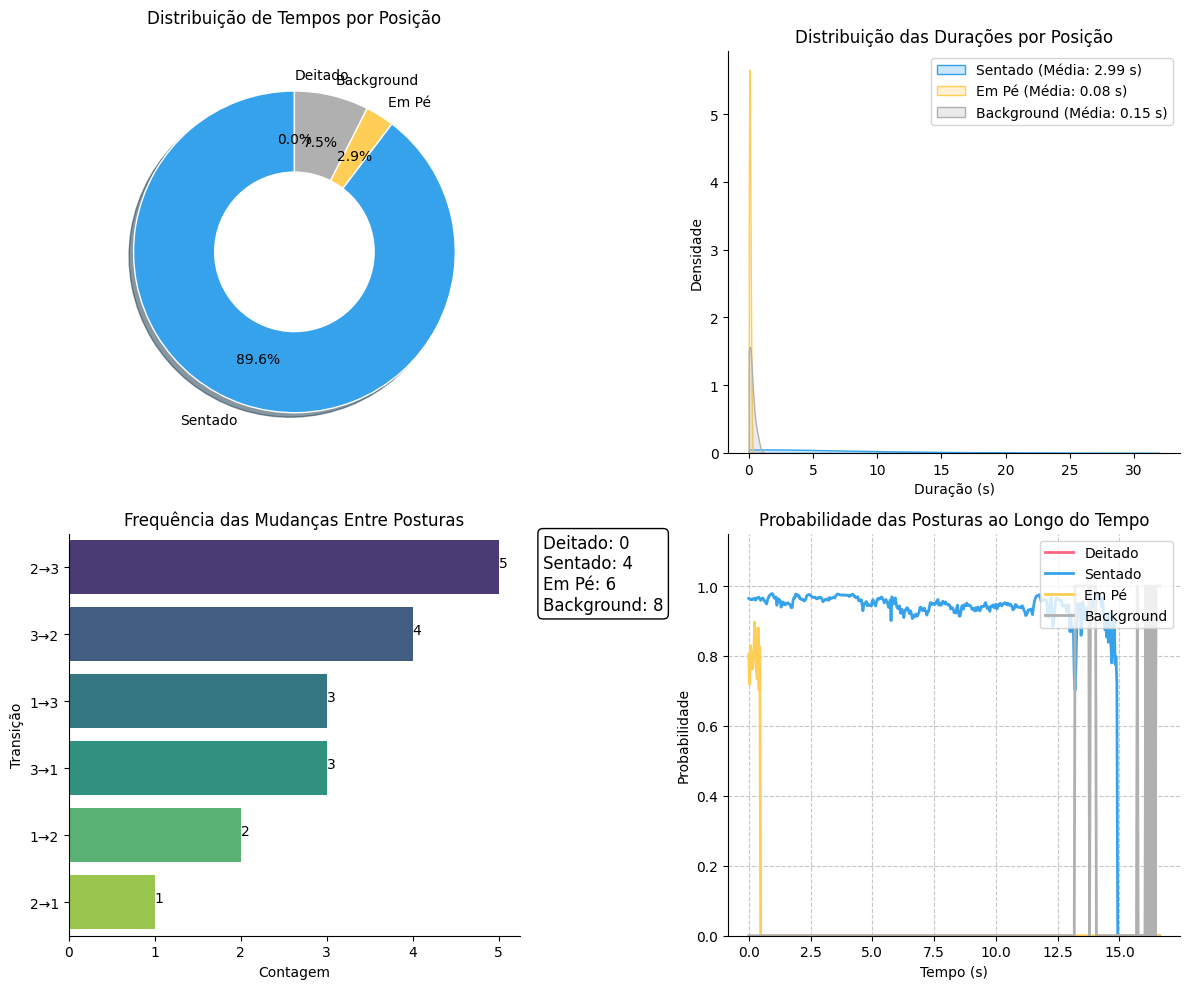

'saida.mp4'

In [30]:
processar_midia_completa('teste.mp4', modelo, tipo='video', caminho_saida='saida.mp4')

### Webcam


# 📊 Relatório de Tempo (em Segundos)

 Categoria      | Tempo (s) | Porcentagem 
---------------|----------|------------|
 **Deitado**   | 0.00  | 0.00% 
 **Sentado**   | 0.20  | 1.52% 
 **Em Pé**     | 7.97    | 60.51% 
 **Background** | 5.00  | 37.97% 
 **Duração do Vídeo**  | 13.17  | 100% 


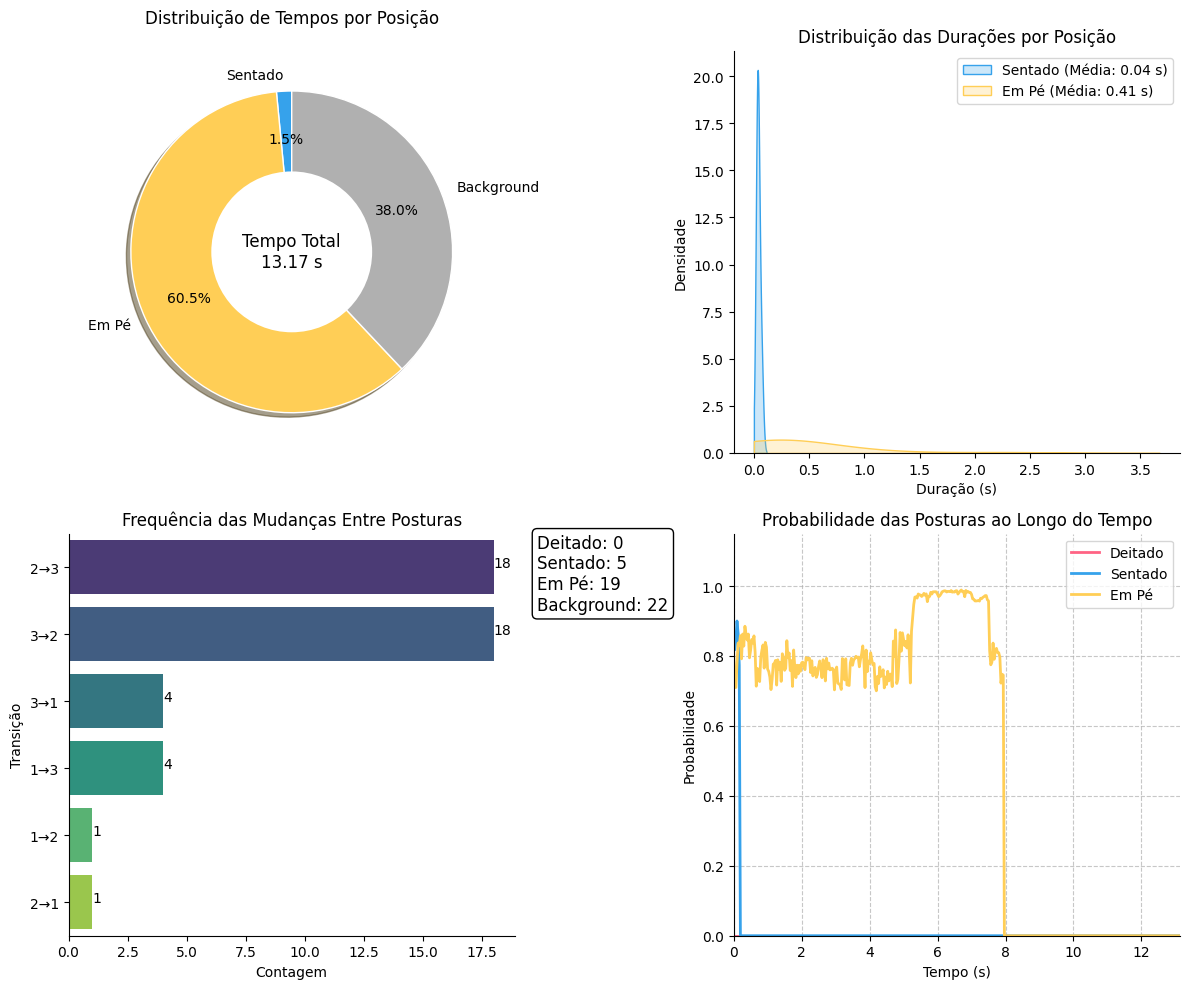

In [ ]:
processar_midia_completa(None, modelo, tipo='webcam')